# Import necessary packages

In [31]:
import datetime
import os
from PIL import Image

import cv2
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import numpy as np
import pydicom
from scipy import ndimage

# Define global variables

In [2]:
DATA_PATH = 'data'
CT_PATH = os.path.join(DATA_PATH, 'CT')
PET_PATH = os.path.join(DATA_PATH, 'PET')
time_now = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
OUTPUT_PATH = os.path.join('output', time_now)
os.makedirs(OUTPUT_PATH, exist_ok=True)

REFERENCE_VIAL_SIZES = [8, 12, 16, 25, 25, 25, 25]

# Load in all the images

In [3]:
data_paths = [
    ('CT', CT_PATH),
    ('PET', PET_PATH)
]
ignored_files = ['.gitkeep', 'v_headers', 'v_headers.index']

all_images = {}
for data_name,data_path in data_paths:

    temp_images = []
    all_direct_paths = os.listdir(data_path)
    all_direct_paths = [p for p in all_direct_paths if p not in ignored_files]
    # Everything is in the form of `MR###...`
    all_direct_paths = sorted(all_direct_paths, key=lambda s: int(s.split('.')[-1]))
    for image_path in all_direct_paths:
        image_dir = os.path.join(data_path, image_path)
        temp_image = pydicom.dcmread(image_dir)
        temp_images.append(temp_image)
    all_images[data_name] = temp_images
    print(data_name, len(temp_images))
    print()


CT 133

PET 133



# Define the location of the desired vials

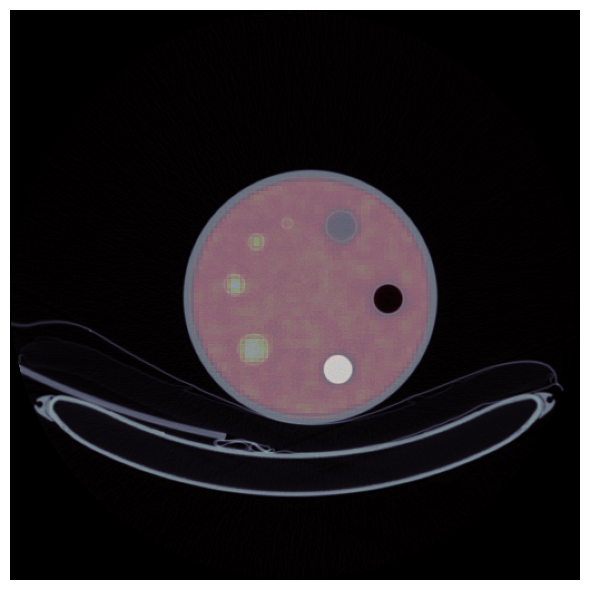

In [58]:
# TODO: do this automatically
CT_SLICE_LOCATION = 105
# Assuming the origins are the same
PET_RESCALE_SLOPE = all_images['PET'][0].RescaleSlope
PET_SCALING_FACTOR = all_images['PET'][0].SliceThickness / 10       # mm
PET_SLICE_LOCATION = int(CT_SLICE_LOCATION * PET_SCALING_FACTOR)

# Double-check that it's the correct location in both
CT_image = all_images['CT'][CT_SLICE_LOCATION]
CT_array = CT_image.pixel_array
CT_array_size = CT_array.shape
CT_pixel_spacing = CT_image.PixelSpacing
CT_positioning = CT_image.ImagePositionPatient
CT_x_vals = np.arange(CT_array_size[0])*CT_pixel_spacing[0] + CT_positioning[0]
CT_y_vals = np.arange(CT_array_size[1])*CT_pixel_spacing[1] + CT_positioning[1]

# Resize the PET images
all_PET_images = np.array([im.pixel_array for im in all_images['PET']])
resized_PET_images = ndimage.zoom(all_PET_images, [PET_SCALING_FACTOR,1,1])
PET_array = resized_PET_images[PET_SLICE_LOCATION,:,:]
PET_array_size = PET_array.shape
PET_image = all_images['PET'][0]
PET_pixel_spacing = PET_image.PixelSpacing
PET_positioning = PET_image.ImagePositionPatient
PET_x_vals = np.arange(PET_array_size[0])*PET_pixel_spacing[0] + PET_positioning[0]
PET_y_vals = np.arange(PET_array_size[1])*PET_pixel_spacing[1] + PET_positioning[1]
PET_DOSE = float(PET_image.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose)
PET_HALF_LIFE = float(PET_image.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife)
PET_START_TIME = datetime.datetime.strptime(str(int(float(PET_image.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime))), '%H%M%S')
PET_ACQUISITION_TIME = datetime.datetime.strptime(str(int(float(PET_image.AcquisitionTime))), '%H%M%S')
PATIENT_WEIGHT = float(PET_image.PatientWeight)

plt.figure(figsize=(6,6))
plt.imshow(CT_array, origin='lower', extent=[min(CT_x_vals),max(CT_x_vals),min(CT_y_vals),max(CT_y_vals)], cmap=plt.cm.bone)
plt.imshow(PET_array, origin='lower', extent=[min(PET_x_vals),max(PET_x_vals),min(PET_y_vals),max(PET_y_vals)], alpha=0.2, cmap=plt.cm.hot)
plt.xlim([min(CT_x_vals), max(CT_x_vals)])
plt.ylim([min(CT_y_vals), max(CT_y_vals)])
ax = plt.gca()
ax.invert_yaxis()
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'PET-CT_registered.png'))
plt.show()

# Automatically detect the vials using the CT image

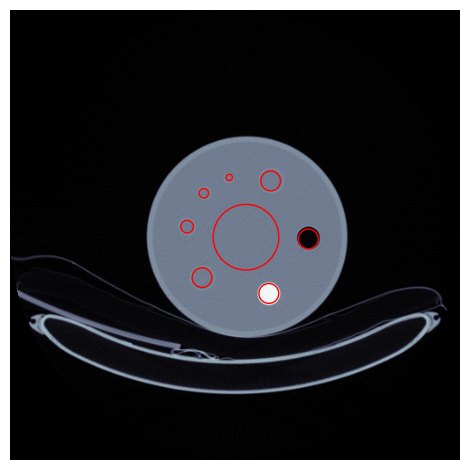

In [59]:
# Set some pre-defined variables which will help find the circles
C_PARAM = 5
MINRADIUS_PARAM = 0
MAXRADIUS_PARAM = 50


# Choose the first repetition as the baseline
n_x = CT_array.shape[0]
n_y = CT_array.shape[1]
all_points = [(x,y) for x in range(n_x) for y in range(n_y)]

# Make the image binary
gray = CT_array.copy() * (255 / np.max(CT_array))
gray = gray.astype(np.uint8)
# gray = cv2.adaptiveThreshold(gray, np.max(gray), cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize=5, C=C_PARAM)
# plt.figure()
# plt.imshow(gray, cmap=plt.cm.bone)

# Find the circles
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT_ALT, dp=1.5, param1=1, param2=0.8, minDist=20, minRadius=MINRADIUS_PARAM, maxRadius=MAXRADIUS_PARAM)
circles_background = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT_ALT, dp=1.5, param1=1, param2=0.8, minDist=20, minRadius=MAXRADIUS_PARAM, maxRadius=None)

# Plot the original image
plt.figure()
ax = plt.gca()
plt.imshow(CT_array, cmap='bone')

# center, radius, coordinates
all_circle_info = []
if circles is not None:
	# Adjust the predicted circles to the reference sizes by sorting them
	# NOTE: this assumes the predicted circle size are in the correct order
	# 		and that the centers are correct (or good enough) ... both not
	#		terrible assumptions here
	circles = sorted(np.round(circles[0,:]).astype(int), key=lambda c:c[2])
	# See the difference from the references if desired
	# circle_diams = np.array([2*c[2]*CT_pixel_spacing[0] for c in circles])			# mm

	for i,(x,y,r) in enumerate(circles):
		# Make the radius slightly smaller to ensured it's just inside
		new_r = 0.9*REFERENCE_VIAL_SIZES[i]/2
		temp_patch = Circle((x,y), new_r, fill=None, color='r')
		ax.add_patch(temp_patch)
		# Matplotlib is stupid and does tranformations on patches if plotted
		temp_coordinates = []
		for xx,yy in all_points:
			if (x - xx)**2 + (y - yy)**2 <= r**2:
				temp_coordinates.append((xx,yy))
		all_circle_info.append(((x,y), r, temp_coordinates))

circle_background_coordinates = []
if circles_background is not None:
	circles_background = sorted(np.round(circles_background[0,:]).astype(int), key=lambda c:c[2])

	for i,(x,y,r) in enumerate(circles_background):
		# Make the radius smaller so it gets the inner part of the phantom
		r = r/3
		temp_patch = Circle((x,y), r, fill=None, color='r')
		ax.add_patch(temp_patch)
		# Matplotlib is stupid and does tranformations on patches if plotted
		for xx,yy in all_points:
			if (x - xx)**2 + (y - yy)**2 <= r**2:
				circle_background_coordinates.append((xx,yy))

plt.grid()
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'CT_segmented_areas.png'))
plt.show()

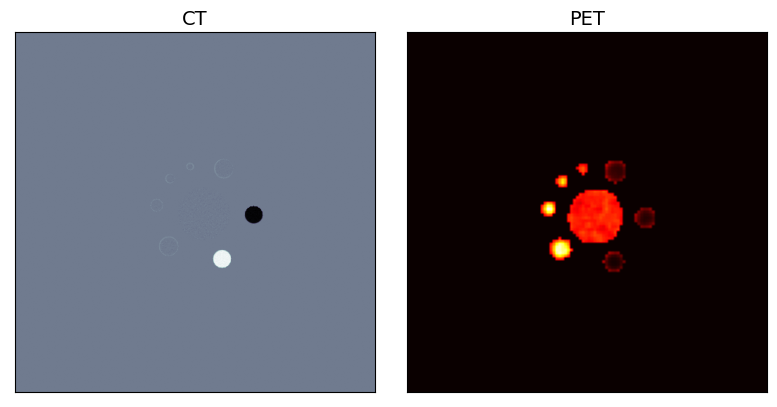

In [60]:
sequence_types = ['CT', 'PET']

fig,ax = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)


all_vial_vals = {}
for i,sequence_type in enumerate(sequence_types):
    all_vial_vals[sequence_type] = []
    temp_circle_patch = [*[ci[2] for ci in all_circle_info], circle_background_coordinates]
    if sequence_type == 'CT':
        temp_im_pixels = CT_array
    elif sequence_type == 'PET':
        temp_im_pixels = PET_array
    voxel_match = np.zeros(temp_im_pixels.shape)

    # TODO: make this robust
    # temp_temp_T1_vials = [[] for _ in range(14)]
    for temp_patch in temp_circle_patch:
        temp_vial_val = []
        for xx,yy in temp_patch:
            if sequence_type == 'CT':
                temp_vol = temp_im_pixels[yy,xx]
                # Convert to HU
                temp_vol = CT_image.RescaleSlope*temp_vol + CT_image.RescaleIntercept
            elif sequence_type == 'PET':
                # Register back to PET indices
                CT_ref_x = CT_positioning[0] + xx*CT_pixel_spacing[0]
                CT_ref_y = CT_positioning[1] + yy*CT_pixel_spacing[1]
                xx = np.argmin(np.abs(np.array(PET_x_vals) - CT_ref_x))
                yy = np.argmin(np.abs(np.array(PET_y_vals) - CT_ref_y))
                temp_vol = temp_im_pixels[yy,xx]
                # Convert to SUV
                delta_time = (PET_ACQUISITION_TIME - PET_START_TIME).seconds
                temp_vol = (temp_vol * (PATIENT_WEIGHT*1000) * PET_RESCALE_SLOPE) / (PET_DOSE * (2**(-delta_time/PET_HALF_LIFE)))
            voxel_match[yy,xx] = temp_vol
            temp_vial_val.append(temp_vol)
        all_vial_vals[sequence_type].append(temp_vial_val)

    if sequence_type == 'CT':
        ax[i].imshow(voxel_match, extent=[min(CT_x_vals),max(CT_x_vals),min(CT_y_vals),max(CT_y_vals)], vmin=-1024, vmax=1024, cmap=plt.cm.bone)
    elif sequence_type == 'PET':
        ax[i].imshow(voxel_match, extent=[min(PET_x_vals),max(PET_x_vals),min(PET_y_vals),max(PET_y_vals)], cmap=plt.cm.hot)
    ax[i].set_title(sequence_type, fontsize=14)
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticklabels([])
    ax[i].set_yticks([])

plt.xlim([min(CT_x_vals), max(CT_x_vals)])
plt.ylim([min(CT_y_vals), max(CT_y_vals)])
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'PET-CT_segmented_areas_isolated.png'))
plt.show()

In [62]:
# vial_names = [
#     '8 mm Active',      # smallest area
#     '12 mm Active',     # 2nd smallest area
#     '16 mm Active',     # 3rd smallest area
#     '25 mm Active',     # mid CT, high PET
#     'Teflon',           # high CT, low PET
#     'Air',              # low CT, low PET
#     'Water'             # mid CT, low PET
#     'Background'        # largest area
# ]

sorted_num_voxels = sorted([(i,len(vol)) for i,vol in enumerate(all_vial_vals['CT'])], key=lambda v:v[1])
active_8mm_ind = sorted_num_voxels[0][0]
active_12mm_ind = sorted_num_voxels[1][0]
active_16mm_ind = sorted_num_voxels[2][0]
background_ind = sorted_num_voxels[-1][0]
mean_vals_CT = [np.mean(vol) for vol in all_vial_vals['CT']]
mean_vals_PET = [np.mean(vol) for vol in all_vial_vals['PET']]
air_ind = 3 + np.argmin(mean_vals_CT[3:])
teflon_ind = 3 + np.argmax(mean_vals_CT[3:])
active_25mm_ind = 3 + np.argmax(mean_vals_PET[3:])
used_inds = [background_ind, active_8mm_ind, active_12mm_ind, active_16mm_ind, active_25mm_ind, air_ind, teflon_ind]
water_ind = list(set(range(len(mean_vals_CT))) - set(used_inds))[0]

# The CT and the PET will be the same indices
vial_matches = {
    '8 mm Active': {
        'CT': all_vial_vals['CT'][sorted_num_voxels[active_8mm_ind][0]],
        'PET': all_vial_vals['PET'][sorted_num_voxels[active_8mm_ind][0]]
    },
    '12 mm Active': {
        'CT': all_vial_vals['CT'][sorted_num_voxels[active_12mm_ind][0]],
        'PET': all_vial_vals['PET'][sorted_num_voxels[active_12mm_ind][0]]
    },
    '16 mm Active': {
        'CT': all_vial_vals['CT'][sorted_num_voxels[active_16mm_ind][0]],
        'PET': all_vial_vals['PET'][sorted_num_voxels[active_16mm_ind][0]]
    },
    '25 mm Active': {
        'CT': all_vial_vals['CT'][sorted_num_voxels[active_25mm_ind][0]],
        'PET': all_vial_vals['PET'][sorted_num_voxels[active_25mm_ind][0]]
    },
    'Teflon': {
        'CT': all_vial_vals['CT'][sorted_num_voxels[teflon_ind][0]],
        'PET': all_vial_vals['PET'][sorted_num_voxels[teflon_ind][0]]
    },
    'Air': {
        'CT': all_vial_vals['CT'][sorted_num_voxels[air_ind][0]],
        'PET': all_vial_vals['PET'][sorted_num_voxels[air_ind][0]]
    },
    'Water': {
        'CT': all_vial_vals['CT'][sorted_num_voxels[water_ind][0]],
        'PET': all_vial_vals['PET'][sorted_num_voxels[water_ind][0]]
    },
    'Background': {
        'CT': all_vial_vals['CT'][sorted_num_voxels[background_ind][0]],
        'PET': all_vial_vals['PET'][sorted_num_voxels[background_ind][0]]
    }
}

# Fill out the ACR table

In [63]:
# A) Contrast - Table 1
active_8mm = np.max(vial_matches['8 mm Active']['PET'])
active_12mm = np.max(vial_matches['12 mm Active']['PET'])
active_16mm = np.max(vial_matches['16 mm Active']['PET'])
active_25mm = np.max(vial_matches['25 mm Active']['PET'])

# B) Scatter/Attenuation - Table 2
background_mean = np.mean(vial_matches['Background']['PET'])

teflon_mean = np.mean(vial_matches['Teflon']['PET'])
teflon_min = np.min(vial_matches['Teflon']['PET'])

air_mean = np.mean(vial_matches['Air']['PET'])
air_min = np.min(vial_matches['Air']['PET'])

water_mean = np.mean(vial_matches['Water']['PET'])
water_min = np.min(vial_matches['Water']['PET'])

# C) Ratio Calculations
ratio_8mm_bkgd = np.max(vial_matches['8 mm Active']['PET'])/np.mean(vial_matches['Background']['PET'])
ratio_12mm_bkgd = np.max(vial_matches['12 mm Active']['PET'])/np.mean(vial_matches['Background']['PET'])
ratio_16mm_bkgd = np.max(vial_matches['16 mm Active']['PET'])/np.mean(vial_matches['Background']['PET'])
ratio_25mm_bkgd = np.max(vial_matches['25 mm Active']['PET'])/np.mean(vial_matches['Background']['PET'])

ratio_8mm_25mm = np.max(vial_matches['8 mm Active']['PET'])/np.max(vial_matches['25 mm Active']['PET'])
ratio_12mm_25mm = np.max(vial_matches['12 mm Active']['PET'])/np.max(vial_matches['25 mm Active']['PET'])
ratio_16mm_25mm = np.max(vial_matches['16 mm Active']['PET'])/np.max(vial_matches['25 mm Active']['PET'])

ratio_air_bone = np.min(vial_matches['Air']['PET'])/np.min(vial_matches['Teflon']['PET'])
ratio_water_bone = np.min(vial_matches['Water']['PET'])/np.min(vial_matches['Teflon']['PET'])

# Save the results to an image file

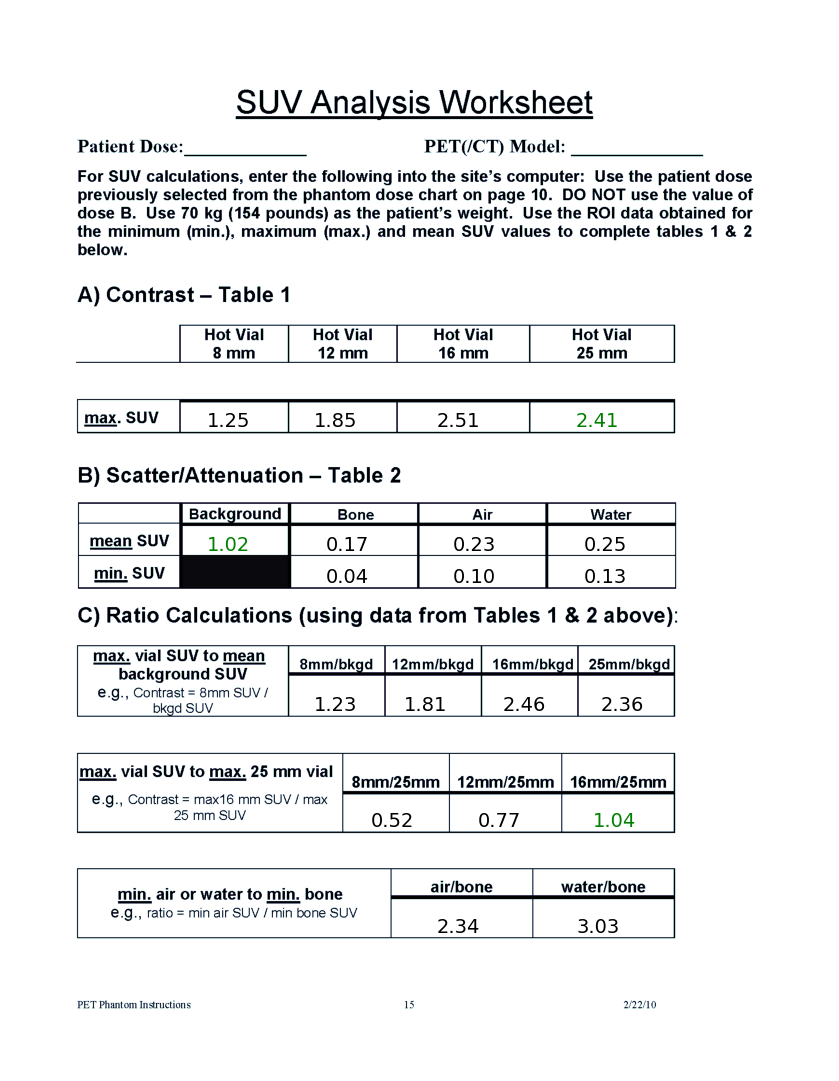

In [64]:
PASSING_CRITERIA = {
    'Mean Background': (background_mean >= 0.85) and (background_mean <= 1.15),
    '25 mm Cylinder': (active_25mm > 1.8) and (active_25mm < 2.8),
    '16/25 Ratio': ratio_16mm_25mm > 0.7
}

ACR_eval_form_img = np.asarray(Image.open(os.path.join('resources', 'PET-Phantom-Instructions-for-Evaluation-of-PET-Image-Quality_Page-15.png')))
ny,nx = ACR_eval_form_img.shape
plt.figure(figsize=(8.5,11))
plt.imshow(ACR_eval_form_img, cmap=plt.cm.bone)
# A)
plt.annotate(f'{active_8mm:.2f}', fontsize=14, xy=(0.24*nx,0.393*ny))
plt.annotate(f'{active_12mm:.2f}', fontsize=14, xy=(0.37*nx,0.393*ny))
plt.annotate(f'{active_16mm:.2f}', fontsize=14, xy=(0.52*nx,0.393*ny))
temp_color = 'g' if PASSING_CRITERIA['25 mm Cylinder'] else 'r'
plt.annotate(f'{active_25mm:.2f}', color=temp_color, fontsize=14, xy=(0.69*nx,0.393*ny))
# B)
# Mean
temp_color = 'g' if PASSING_CRITERIA['Mean Background'] else 'r'
plt.annotate(f'{background_mean:.2f}', color=temp_color, fontsize=14, xy=(0.24*nx,0.51*ny))
plt.annotate(f'{teflon_mean:.2f}', fontsize=14, xy=(0.385*nx,0.51*ny))
plt.annotate(f'{air_mean:.2f}', fontsize=14, xy=(0.54*nx,0.51*ny))
plt.annotate(f'{water_mean:.2f}', fontsize=14, xy=(0.7*nx,0.51*ny))
# Min
plt.annotate(f'{teflon_min:.2f}', fontsize=14, xy=(0.385*nx,0.54*ny))
plt.annotate(f'{air_min:.2f}', fontsize=14, xy=(0.54*nx,0.54*ny))
plt.annotate(f'{water_min:.2f}', fontsize=14, xy=(0.7*nx,0.54*ny))
# C)
# max vial to mean background
plt.annotate(f'{ratio_8mm_bkgd:.2f}', fontsize=14, xy=(0.37*nx,0.66*ny))
plt.annotate(f'{ratio_12mm_bkgd:.2f}', fontsize=14, xy=(0.48*nx,0.66*ny))
plt.annotate(f'{ratio_16mm_bkgd:.2f}', fontsize=14, xy=(0.6*nx,0.66*ny))
plt.annotate(f'{ratio_25mm_bkgd:.2f}', fontsize=14, xy=(0.72*nx,0.66*ny))
# max vial to max 25mm
plt.annotate(f'{ratio_8mm_25mm:.2f}', fontsize=14, xy=(0.44*nx,0.77*ny))
plt.annotate(f'{ratio_12mm_25mm:.2f}', fontsize=14, xy=(0.57*nx,0.77*ny))
temp_color = 'g' if PASSING_CRITERIA['16/25 Ratio'] else 'r'
plt.annotate(f'{ratio_16mm_25mm:.2f}', color=temp_color, fontsize=14, xy=(0.71*nx,0.77*ny))
# min air/water to bone
plt.annotate(f'{ratio_air_bone:.2f}', fontsize=14, xy=(0.52*nx,0.87*ny))
plt.annotate(f'{ratio_water_bone:.2f}', fontsize=14, xy=(0.69*nx,0.87*ny))
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'ACR_passing_results.png'))
plt.show()